In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from torch.utils.data import TensorDataset, DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
class NeuronDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, trial_col='trial_id', neuron_col='neuron_id',
                 feature_cols=['gocue_10ms', 'wheel_spikes_10ms', 'feedback_10ms'], target_col='target'):

      self.trial_col = trial_col
      self.neuron_col = neuron_col
      self.feature_cols = feature_cols # Use the list of feature columns
      self.target_col = target_col

      # Pivot the DataFrame into [trial, neuron] -> feature_matrix
      self.df = dataframe.copy()

      # Sort for consistency
      self.df.sort_values([trial_col, neuron_col], inplace=True)

      # Get unique trial IDs and neuron IDs
      self.trial_ids = self.df[trial_col].unique()
      self.neuron_ids = self.df[neuron_col].unique()
      self.num_trials = len(self.trial_ids)
      self.num_neurons = len(self.neuron_ids)

      # Precompute the [num_trials, total_num_bins, num_neurons] tensor
      self.features_tensor = self._build_feature_tensor()
      self.targets_tensor = self._build_target_tensor()

      # Determine the slicing indices for each feature
      self._feature_indices = self._get_feature_indices()


    def _build_feature_tensor(self):
      # Dimensions: [num_trials, total_num_bins, num_neurons]
      # Assuming each feature column contains a list of lists representing num_bins x num_neurons data

      # Get the number of time bins for each feature column by looking at the first row
      num_bins_per_feature = {col: len(np.squeeze(self.df[col].iloc[0])) for col in self.feature_cols}
      total_num_bins = sum(num_bins_per_feature.values())

      feature_tensor = torch.zeros((self.num_trials, total_num_bins, self.num_neurons), dtype=torch.float32)

      # Build a lookup table: trial_id -> index, neuron_id -> index
      trial_index = {tid: i for i, tid in enumerate(self.trial_ids)}
      neuron_index = {nid: i for i, nid in enumerate(self.neuron_ids)}

      for _, row in self.df.iterrows():
        t_idx = trial_index[row[self.trial_col]]
        n_idx = neuron_index[row[self.neuron_col]]

        current_bin_idx = 0
        for col in self.feature_cols:
            num_bins = num_bins_per_feature[col]
            feature_data = torch.tensor(np.squeeze(row[col]), dtype=torch.float32)
            feature_tensor[t_idx, current_bin_idx : current_bin_idx + num_bins, n_idx] = feature_data
            current_bin_idx += num_bins


      return feature_tensor

    def _build_target_tensor(self):
      # One target per trial — assumes all rows of same trial have same target
      target_map = self.df.drop_duplicates(subset=self.trial_col).set_index(self.trial_col)[self.target_col]
      # Convert target_angle (-90, 90) to binary labels (0, 1)
      target_tensor = torch.tensor([1 if target == 90 else 0 for target in target_map.values], dtype=torch.long)
      return target_tensor

    def _get_feature_indices(self):
        # Calculate the start and end indices for each feature in the concatenated tensor
        num_bins_per_feature = {col: len(np.squeeze(self.df[col].iloc[0])) for col in self.feature_cols}
        feature_indices = {}
        current_bin_idx = 0
        for col in self.feature_cols:
            num_bins = num_bins_per_feature[col]
            feature_indices[col] = (current_bin_idx, current_bin_idx + num_bins)
            current_bin_idx += num_bins
        return feature_indices


    def __len__(self):
      return self.num_trials

    def __getitem__(self, idx):
      # Extract slices for each feature based on precomputed indices using the actual feature column names
      gc_col = self.feature_cols[0]
      mm_col = self.feature_cols[1]
      fb_col = self.feature_cols[2]

      x_gc_indices = self._feature_indices[gc_col]
      x_mm_indices = self._feature_indices[mm_col]
      x_fb_indices = self._feature_indices[fb_col]

      x_gc = self.features_tensor[idx, x_gc_indices[0]:x_gc_indices[1], :]
      x_mm = self.features_tensor[idx, x_mm_indices[0]:x_mm_indices[1], :]
      x_fb = self.features_tensor[idx, x_fb_indices[0]:x_fb_indices[1], :]


      # return (x_gc, x_mm, x_fb), self.targets_tensor[idx]
      return (x_gc, x_mm, x_fb), self.targets_tensor[idx]

In [4]:
class threeHeadsLSTM(nn.Module):
  def __init__(self, n_neurons, hidden_dim, num_layers=1):

    super(threeHeadsLSTM, self).__init__()
    self.n_neurons = n_neurons
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers

    # Go-Cue centered LSTM
    self.gcLSTM = nn.LSTM(input_size=n_neurons, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

    # Movement centered LSTM
    self.mmLSTM = nn.LSTM(input_size=n_neurons, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

    # Feedback centered LSTM
    self.fbLSTM = nn.LSTM(input_size=n_neurons, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

    self.classifier = nn.Sequential(
        nn.Linear(hidden_dim, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 2)
    )

  def forward(self, x_gc, x_mm, x_fb):
    # Each input: (batch_size, bins, n_neurons)
    # Each output: (batch_size, bins, hidden_dim)

    # LSTM has two outputs, hidden state and cell state.

    out_gc, (h_gc, c_gc) = self.gcLSTM(x_gc)
    out_mm, (h_mm, c_mm) = self.mmLSTM(x_mm, (h_gc, c_gc))
    out_fb, (h_fb, c_fb) = self.fbLSTM(x_fb, (h_mm, c_mm))

    # out_gc, (h_gc, c_gc) = self.gcLSTM(x_gc)
    # out_mm, (h_mm, c_mm) = self.mmLSTM(x_mm)
    # out_fb, (h_fb, c_fb) = self.fbLSTM(x_fb)

    # combined = torch.cat((out_gc[:, -1, :], out_mm[:, -1, :], out_fb[:, -1, :]), dim=1)
    logits = self.classifier(h_fb[-1])

    return logits

In [5]:
df = pd.read_pickle('combined_data_updated.pkl')
df.head(5)

,mouse_name,date,cluster_index,allen_ontology,stimulus_times,feedback_times,gocue_times,contrast_right,contrast_left,trial_start,trial_end,move_start,move_end,wheel_spikes_10ms,stimulus_side,target_angle,gocue_10ms,feedback_10ms
0,Cori,2016-12-14,1,MOs,65.269408,66.456227,66.296625,0.0,1.0,64.769408,67.269408,65.432504,67.008504,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",ipsilateral,90,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,Cori,2016-12-14,1,MOs,71.202703,72.640326,72.077117,0.5,0.0,70.702703,73.202703,71.414504,72.917504,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",contralateral,-90,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Cori,2016-12-14,1,MOs,76.052380,77.038396,76.877593,0.5,1.0,75.552380,78.052380,76.232504,77.334504,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",ipsilateral,90,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,Cori,2016-12-14,1,MOs,111.066939,112.353759,112.138155,0.5,1.0,110.566939,113.066939,111.265504,112.687504,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",ipsilateral,90,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,Cori,2016-12-14,1,MOs,115.982617,116.868631,116.628627,0.0,0.5,115.482617,117.982617,116.279504,117.186504,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",ipsilateral,90,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [6]:
### Run Example

dataset = NeuronDataset(df, trial_col='trial_start', neuron_col='cluster_index',
                        feature_cols=['gocue_10ms', 'wheel_spikes_10ms', 'feedback_10ms'], target_col='target_angle')
loader = torch.utils.data.DataLoader(dataset, batch_size=8)

for (x_gc, x_mm, x_fb), targets in loader:
  print(x_gc.shape, x_mm.shape, x_fb.shape, targets.shape)
  break

torch.Size([8, 100, 567]) torch.Size([8, 100, 567]) torch.Size([8, 100, 567]) torch.Size([8])


In [7]:
all_trial_ids = df['trial_start'].unique()
train_ids, temp_ids = train_test_split(all_trial_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

train_df = df[df['trial_start'].isin(train_ids)]
val_df = df[df['trial_start'].isin(val_ids)]
test_df = df[df['trial_start'].isin(test_ids)]

print(f"Total Trials: {len(all_trial_ids)}")
print(f"Number of trials for training: {len(train_ids)}")
print(f"Number of trials for validation: {len(val_ids)}")
print(f"Number of trails for testing: {len(test_ids)}")

Total Trials: 1031
Number of trials for training: 721
Number of trials for validation: 155
Number of trails for testing: 155


In [8]:
feature_columns = ['gocue_10ms', 'wheel_spikes_10ms', 'feedback_10ms']
target_column = 'target_angle'
train_dataset = NeuronDataset(train_df, trial_col='trial_start', neuron_col='cluster_index',
                              feature_cols=feature_columns, target_col=target_column)
Val_dataset = NeuronDataset(val_df, trial_col='trial_start', neuron_col='cluster_index',
                            feature_cols=feature_columns, target_col=target_column)
test_dataset = NeuronDataset(test_df, trial_col='trial_start', neuron_col='cluster_index',
                             feature_cols=feature_columns, target_col=target_column)

batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(Val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_targets = train_dataset.targets_tensor.numpy()
print(f"Class balance in training set:")
print(f"Class 0: {(train_targets == 0).sum()} ({(train_targets == 0).mean():.2%})")
print(f"Class 1: {(train_targets == 1).sum()} ({(train_targets == 1).mean():.2%})")
print(train_dataset.targets_tensor[:10])

Class balance in training set:
Class 0: 374 (51.87%)
Class 1: 347 (48.13%)
tensor([0, 1, 0, 0, 1, 0, 1, 1, 1, 0])


Training Started!
Epoch 1/50, Training Loss: 0.7046, Validation Loss: 0.6925
Epoch 2/50, Training Loss: 0.5943, Validation Loss: 0.6893
Epoch 3/50, Training Loss: 0.5472, Validation Loss: 0.6832
Epoch 4/50, Training Loss: 0.5033, Validation Loss: 0.6757
Epoch 5/50, Training Loss: 0.4488, Validation Loss: 0.6700
Epoch 6/50, Training Loss: 0.3928, Validation Loss: 0.6761
Epoch 7/50, Training Loss: 0.3630, Validation Loss: 0.7125
Epoch 8/50, Training Loss: 0.3121, Validation Loss: 0.7517
Epoch 9/50, Training Loss: 0.2897, Validation Loss: 0.7993
Epoch 10/50, Training Loss: 0.2500, Validation Loss: 0.8469
Epoch 11/50, Training Loss: 0.2243, Validation Loss: 0.9757
Epoch 12/50, Training Loss: 0.2050, Validation Loss: 1.0873
Epoch 13/50, Training Loss: 0.1813, Validation Loss: 1.1446
Epoch 14/50, Training Loss: 0.2089, Validation Loss: 1.2723
Epoch 15/50, Training Loss: 0.1739, Validation Loss: 1.2711
Early stopping triggered at epoch 15
Training Complete!
Test Loss: 1.3997, Accuracy: 0.4452

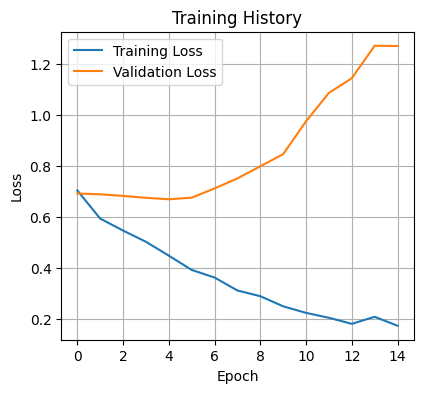

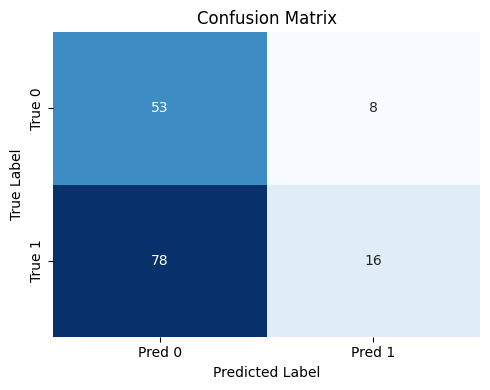

Predicted probabilities: [0.6047752  0.25597784 0.65526414 0.00816884 0.32151064 0.01364667
 0.00398099 0.15670706 0.03064441 0.16485831 0.00174114 0.98734075
 0.68952763 0.18742667 0.09627416 0.35173497 0.20344962 0.00852439
 0.01891336 0.01513633 0.02017891 0.19411123 0.06437078 0.98460776
 0.47512522 0.00291463 0.04592353 0.43970153 0.10593617 0.21835192
 0.03833168 0.3296909  0.01062611 0.10660003 0.93413603 0.15623824
 0.00870882 0.01260439 0.855885   0.13079798 0.18169172 0.74426323
 0.11142097 0.006352   0.26511016 0.08613633 0.9907934  0.13140613
 0.27345002 0.12864944 0.03237854 0.00495877 0.41467908 0.09740862
 0.5744341  0.20043103 0.9796307  0.34750035 0.31574303 0.01213289
 0.03985437 0.05356088 0.15432623 0.1411127  0.15024507 0.22255853
 0.34938437 0.4732988  0.32573348 0.97809464 0.03902026 0.9383291
 0.26499918 0.03534828 0.13307658 0.07261629 0.06954353 0.11353289
 0.15155491 0.08230237 0.44078436 0.02389925 0.35173497 0.50937665
 0.08304109 0.03041436 0.02740384 0.02

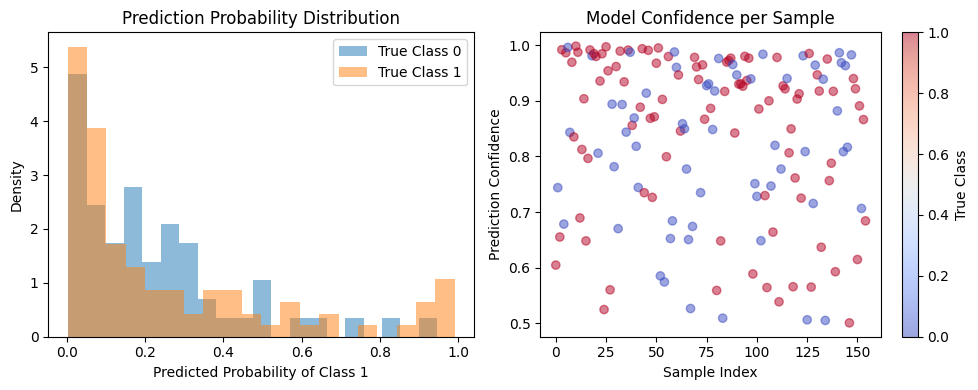

In [9]:
n_neurons = train_dataset.num_neurons
hidden_dim = 64

model = threeHeadsLSTM(n_neurons, hidden_dim).to(device)
lsf = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
num_epochs = 50

patience = 10
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

train_losses = []
val_losses = []

print("Training Started!")
for epoch in range(num_epochs):
  model.train()
  total_training_loss = 0

  for data_batch, target_batch in train_loader:
    x_gc, x_mm, x_fb = data_batch
    x_gc, x_mm, x_fb, target_batch = x_gc.to(device), x_mm.to(device), x_fb.to(device), target_batch.to(device)
    optimizer.zero_grad()
    output= model(x_gc, x_mm, x_fb)
    loss = lsf(output, target_batch)
    loss.backward()
    optimizer.step()
    total_training_loss += loss.item()

  model.eval()
  total_val_loss = 0

  with torch.no_grad():
    for data_batch, target_batch in val_loader:
      x_gc, x_mm, x_fb = data_batch
      x_gc, x_mm, x_fb, target_batch = x_gc.to(device), x_mm.to(device), x_fb.to(device), target_batch.to(device)
      output = model(x_gc, x_mm, x_fb)
      loss = lsf(output, target_batch)
      total_val_loss += loss.item()

  avg_training_loss = total_training_loss / len(train_loader)
  avg_val_loss = total_val_loss / len(val_loader)

  train_losses.append(avg_training_loss)
  val_losses.append(avg_val_loss)

  print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_training_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

  # Early stopping
  if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    patience_counter = 0
    best_model_state = model.state_dict()
  else:
    patience_counter += 1
    if patience_counter >= patience:
      print(f"Early stopping triggered at epoch {epoch+1}")
      break

print("Training Complete!")

# Plot training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)

predictions = []
targets = []

model.eval()
total_test_loss = 0

with torch.no_grad():
    for data_batch, target_batch in test_loader:
        x_gc, x_mm, x_fb = data_batch
        x_gc, x_mm, x_fb, target_batch = x_gc.to(device), x_mm.to(device), x_fb.to(device), target_batch.to(device)
        output= model(x_gc, x_mm, x_fb)
        loss = lsf(output, target_batch)
        total_test_loss += loss.item()
        predictions.append(output.cpu())
        targets.append(target_batch.cpu())

predictions = torch.cat(predictions)
targets = torch.cat(targets)

probs = torch.softmax(predictions, dim=1)[:, 1]
pred_labels = predictions.argmax(dim=1)

target_np = targets.numpy()
pred_np = pred_labels.numpy()

avg_test_loss = total_test_loss / len(test_loader)
accuracy = accuracy_score(target_np, pred_np)
cMatrix = confusion_matrix(target_np, pred_np)
print(f"Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")

plt.figure(figsize=(5, 4))
sns.heatmap(cMatrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print("Predicted probabilities:", probs.numpy())
print("Predicted labels:", pred_np)
print("True labels:", target_np)

# Additional diagnostic plots
plt.figure(figsize=(10, 4))

# Plot probability distribution
plt.subplot(1, 2, 1)
plt.hist(probs[target_np == 0], bins=20, alpha=0.5, label='True Class 0', density=True)
plt.hist(probs[target_np == 1], bins=20, alpha=0.5, label='True Class 1', density=True)
plt.xlabel('Predicted Probability of Class 1')
plt.ylabel('Density')
plt.title('Prediction Probability Distribution')
plt.legend()

# Plot prediction confidence
plt.subplot(1, 2, 2)
confidence = torch.max(torch.softmax(predictions, dim=1), dim=1)[0].numpy()
plt.scatter(range(len(confidence)), confidence, c=target_np, cmap='coolwarm', alpha=0.5)
plt.xlabel('Sample Index')
plt.ylabel('Prediction Confidence')
plt.title('Model Confidence per Sample')
plt.colorbar(label='True Class')
plt.tight_layout()
plt.show()

In [ ]:
# !pip install torchviz -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 136.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.3 MB/s eta 0:00:00


In [ ]:
# from torchviz import make_dot

# # Assuming you have already created an instance of your model
# # For visualization purposes, we can use a dummy input
# n_neurons = train_dataset.num_neurons
# hidden_dim = 64
# model = threeHeadsLSTM(n_neurons, hidden_dim)

# # Create dummy input tensors with appropriate dimensions
# dummy_x_gc = torch.randn(1, 100, n_neurons)  # batch_size=1, bins=100, n_neurons
# dummy_x_mm = torch.randn(1, 100, n_neurons)
# dummy_x_fb = torch.randn(1, 100, n_neurons)


# # Get the output and create the graph
# output= model(dummy_x_gc, dummy_x_mm, dummy_x_fb)

# # make_dot creates a graph from the output tensor
# dot = make_dot(output, params=dict(model.named_parameters()))

# # To display the graph in Colab, you can save it as a file and then display the file.
# # Or, if graphviz is installed and configured, it can be displayed directly.
# # Let's save it as a PNG file.
# dot.format = 'png'
# dot.render('threeHeadsLSTM_model_architecture', view=False) # Saves as threeHeadsLSTM_model_architecture.png

# print("Model architecture visualization saved as threeHeadsLSTM_model_architecture.png")

# # If you have graphviz installed locally and running a local notebook, you could use view=True
# # dot.render('threeHeadsLSTM_model_architecture', view=True)

Model architecture visualization saved as threeHeadsLSTM_model_architecture.png


The model architecture has been saved as `threeHeadsLSTM_model_architecture.png`. You can view this file in the file browser.

Note: Direct display of the graph within the notebook might require additional graphviz setup in some environments. Saving to a file is a more universally compatible approach in Colab.

=== DIAGNOSTIC: Testing if data contains learnable patterns ===

Extracting features...

1. Testing Simple Models:
----------------------------------------
Logistic Regression - Train: 0.975, Test: 0.452
Random Forest - Train: 0.878, Test: 0.413

2. Testing with most active neurons only:
----------------------------------------
Logistic Regression (top 100 neurons) - Test: 0.406

3. Visualizing data separability with PCA:
----------------------------------------
Variance explained by first 2 PCs: 16.0%


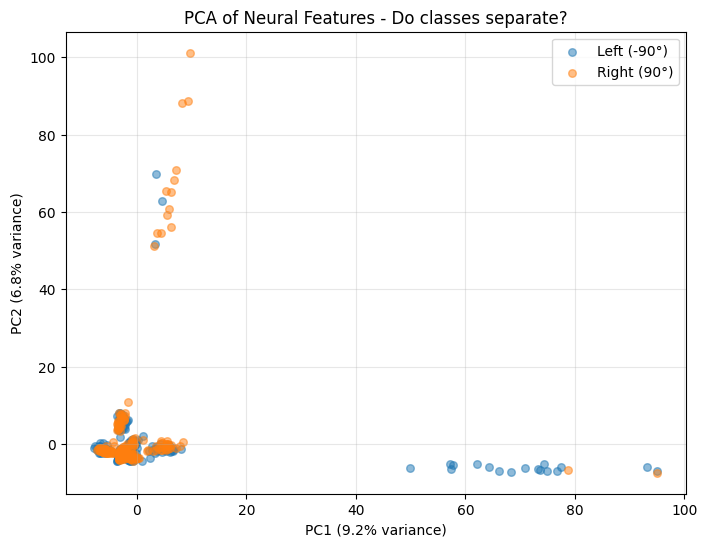


4. Checking prediction distributions:
----------------------------------------
Logistic Regression probability range: [0.000, 1.000]
Predictions close to 0.5: 6 / 155

=== SUMMARY ===
❌ Simple models cannot learn from this data (accuracy < 55%)
   This suggests the neural data may not contain discriminative information
   for distinguishing left vs right targets.

Possible reasons:
   - These neurons don't encode target direction
   - Wrong time windows (try different alignments)
   - Need different features (e.g., spike timing, correlations)
   - Data quality issues

Your LSTM accuracy: 40.0%
Simple model accuracy: 45.2%
Improvement needed: 5.2 percentage points


In [ ]:
print("=== DIAGNOSTIC: Testing if data contains learnable patterns ===\n")

# 1. Extract simple features (mean firing rates)
def extract_mean_features(dataset):
    features = []
    for i in range(len(dataset)):
        (x_gc, x_mm, x_fb), _ = dataset[i]
        # Just use mean firing rate for each neuron in each epoch
        feat = np.concatenate([
            x_gc.mean(dim=0).numpy(),
            x_mm.mean(dim=0).numpy(),
            x_fb.mean(dim=0).numpy()
        ])
        features.append(feat)
    return np.array(features)

print("Extracting features...")
X_train = extract_mean_features(train_dataset)
y_train = train_dataset.targets_tensor.numpy()
X_test = extract_mean_features(test_dataset)
y_test = test_dataset.targets_tensor.numpy()

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Test simple models
print("\n1. Testing Simple Models:")
print("-" * 40)

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
lr_train_acc = lr.score(X_train_scaled, y_train)
lr_test_acc = lr.score(X_test_scaled, y_test)
print(f"Logistic Regression - Train: {lr_train_acc:.3f}, Test: {lr_test_acc:.3f}")

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_train_acc = rf.score(X_train_scaled, y_train)
rf_test_acc = rf.score(X_test_scaled, y_test)
print(f"Random Forest - Train: {rf_train_acc:.3f}, Test: {rf_test_acc:.3f}")

# 3. Check if using only the most active neurons helps
print("\n2. Testing with most active neurons only:")
print("-" * 40)
# Find neurons with highest variance
neuron_variance = X_train.var(axis=0)
top_neurons = np.argsort(neuron_variance)[-100:]  # Top 100 most variable neurons

X_train_top = X_train[:, top_neurons]
X_test_top = X_test[:, top_neurons]

scaler_top = StandardScaler()
X_train_top_scaled = scaler_top.fit_transform(X_train_top)
X_test_top_scaled = scaler_top.transform(X_test_top)

lr_top = LogisticRegression(max_iter=1000, random_state=42)
lr_top.fit(X_train_top_scaled, y_train)
lr_top_test_acc = lr_top.score(X_test_top_scaled, y_test)
print(f"Logistic Regression (top 100 neurons) - Test: {lr_top_test_acc:.3f}")

# 4. Visualize with PCA
print("\n3. Visualizing data separability with PCA:")
print("-" * 40)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
print(f"Variance explained by first 2 PCs: {pca.explained_variance_ratio_.sum():.1%}")

plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[y_train==0, 0], X_train_pca[y_train==0, 1],
            alpha=0.5, label='Left (-90°)', s=30)
plt.scatter(X_train_pca[y_train==1, 0], X_train_pca[y_train==1, 1],
            alpha=0.5, label='Right (90°)', s=30)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('PCA of Neural Features - Do classes separate?')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. Check class balance in predictions
print("\n4. Checking prediction distributions:")
print("-" * 40)
lr_probs = lr.predict_proba(X_test_scaled)[:, 1]
print(f"Logistic Regression probability range: [{lr_probs.min():.3f}, {lr_probs.max():.3f}]")
print(f"Predictions close to 0.5: {np.sum(np.abs(lr_probs - 0.5) < 0.1)} / {len(lr_probs)}")

# 6. Summary
print("\n=== SUMMARY ===")
if lr_test_acc < 0.55 and rf_test_acc < 0.55:
    print("❌ Simple models cannot learn from this data (accuracy < 55%)")
    print("   This suggests the neural data may not contain discriminative information")
    print("   for distinguishing left vs right targets.")
    print("\nPossible reasons:")
    print("   - These neurons don't encode target direction")
    print("   - Wrong time windows (try different alignments)")
    print("   - Need different features (e.g., spike timing, correlations)")
    print("   - Data quality issues")
else:
    print("✓ Simple models CAN learn from this data!")
    print("  The LSTM architecture might be too complex.")

print(f"\nYour LSTM accuracy: 40.0%")
print(f"Simple model accuracy: {lr_test_acc:.1%}")
print(f"Improvement needed: {(lr_test_acc - 0.4)*100:.1f} percentage points")

In [ ]:
print("=== UNDERSTANDING THE DATALOADER DIFFERENCE ===\n")

# 1. Check the data structure
print("1. Data Structure Analysis:")
print("-" * 50)

# Look at the actual data
print(f"Total rows in df: {len(df)}")
print(f"Unique trials: {len(df['trial_start'].unique())}")
print(f"Unique neurons: {len(df['cluster_index'].unique())}")

# Check shape of spike data
first_row = df.iloc[0]
print(f"\nShape of gocue_10ms in first row: {np.array(first_row['gocue_10ms']).shape}")
print(f"Shape of wheel_spikes_10ms in first row: {np.array(first_row['wheel_spikes_10ms']).shape}")

# 2. Your teammate's approach
print("\n2. Your Teammate's Approach:")
print("-" * 50)
print("- Each row in DataFrame becomes one sample")
print("- Model sees one neuron at a time")
print(f"- Total samples for training: {len(df)}")
print("- This treats each neuron independently!")

# 3. Your approach
print("\n3. Your Approach:")
print("-" * 50)
print("- Each trial becomes one sample")
print("- Model sees all neurons together")
print(f"- Total samples for training: {len(df['trial_start'].unique())}")
print("- This preserves population-level information!")

# Let's implement your teammate's approach
class SimpleDataset(Dataset):
    """Teammate's approach - each row is a sample"""
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Extract features - assuming these are already numpy arrays
        gocue = torch.tensor(np.array(row['gocue_10ms']), dtype=torch.float32).squeeze()
        wheel = torch.tensor(np.array(row['wheel_spikes_10ms']), dtype=torch.float32).squeeze()
        feedback = torch.tensor(np.array(row['feedback_10ms']), dtype=torch.float32).squeeze()

        # Target
        label = 0 if row['target_angle'] == -90 else 1

        return {
            'gocue': gocue,
            'wheel': wheel,
            'feedback': feedback,
            'label': torch.tensor(label, dtype=torch.long),
            'trial_id': row['trial_start'],
            'neuron_id': row['cluster_index']
        }

# Create dataset with teammate's approach
teammate_dataset = SimpleDataset(train_df)

print("\n4. Comparing Approaches:")
print("-" * 50)

# Your approach - get one sample
your_sample = train_dataset[0]
x_gc, x_mm, x_fb = your_sample[0]
print(f"Your approach - Sample 0 shapes:")
print(f"  GoCue: {x_gc.shape}, Movement: {x_mm.shape}, Feedback: {x_fb.shape}")

# Teammate's approach - get one sample
teammate_sample = teammate_dataset[0]
print(f"\nTeammate's approach - Sample 0 shapes:")
print(f"  GoCue: {teammate_sample['gocue'].shape}")
print(f"  Movement: {teammate_sample['wheel'].shape}")
print(f"  Feedback: {teammate_sample['feedback'].shape}")

# 5. Check if data is actually per-neuron
print("\n5. Verifying Data Format:")
print("-" * 50)

# Check a few rows to see if each row is indeed one neuron
for i in range(min(3, len(df))):
    row = df.iloc[i]
    gc_data = np.array(row['gocue_10ms'])
    print(f"Row {i}: trial={row['trial_start']}, neuron={row['cluster_index']}, gocue_shape={gc_data.shape}")

# 6. The Critical Issue
print("\n=== CRITICAL ANALYSIS ===")
print("The approaches are fundamentally different:")
print("\n1. YOUR APPROACH (Population-level):")
print("   - Preserves relationships between neurons")
print("   - Can learn population codes")
print("   - Correct for neural decoding")
print("   - BUT: Only ~1000 samples for training")

print("\n2. TEAMMATE'S APPROACH (Single-neuron):")
print("   - Treats each neuron independently")
print("   - Ignores population interactions")
print("   - Much more training data (~80,000 samples)")
print("   - BUT: Loses critical population information")

# Let's test teammate's approach with simple model
print("\n7. Quick Test of Teammate's Approach:")
print("-" * 50)

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Extract features using teammate's approach (single neuron)
def extract_single_neuron_features(dataset, n_samples=5000):
    features = []
    labels = []

    for i in range(min(n_samples, len(dataset))):
        sample = dataset[i]
        # Concatenate all time bins
        feat = np.concatenate([
            sample['gocue'].numpy(),
            sample['wheel'].numpy(),
            sample['feedback'].numpy()
        ])
        features.append(feat)
        labels.append(sample['label'].item())

    return np.array(features), np.array(labels)

# Test with simple model
X_single, y_single = extract_single_neuron_features(teammate_dataset)
scaler = StandardScaler()
X_single_scaled = scaler.fit_transform(X_single)

# Split for testing
split_idx = int(0.8 * len(X_single))
X_train_single = X_single_scaled[:split_idx]
y_train_single = y_single[:split_idx]
X_test_single = X_single_scaled[split_idx:]
y_test_single = y_single[split_idx:]

lr_single = LogisticRegression(max_iter=1000)
lr_single.fit(X_train_single, y_train_single)
acc_single = lr_single.score(X_test_single, y_test_single)
print(f"Single-neuron approach accuracy: {acc_single:.3f}")

print("\n=== RECOMMENDATION ===")
if acc_single > 0.55:
    print("✓ Teammate's approach works better!")
    print("  This suggests individual neurons contain information")
    print("  but population-level patterns might be too noisy")
else:
    print("❌ Both approaches fail")
    print("  The neurons don't encode target direction")
    print("  regardless of how we structure the data")

print("\nTo use teammate's exact approach, you need to:")
print("1. Reshape your data so each row = one neuron")
print("2. Use their simpler LSTM architecture")
print("3. Have MANY more training samples")

=== UNDERSTANDING THE DATALOADER DIFFERENCE ===

1. Data Structure Analysis:
--------------------------------------------------
Total rows in df: 114826
Unique trials: 1031
Unique neurons: 567

Shape of gocue_10ms in first row: (1, 100)
Shape of wheel_spikes_10ms in first row: (1, 100)

2. Your Teammate's Approach:
--------------------------------------------------
- Each row in DataFrame becomes one sample
- Model sees one neuron at a time
- Total samples for training: 114826
- This treats each neuron independently!

3. Your Approach:
--------------------------------------------------
- Each trial becomes one sample
- Model sees all neurons together
- Total samples for training: 1031
- This preserves population-level information!

4. Comparing Approaches:
--------------------------------------------------
Your approach - Sample 0 shapes:
  GoCue: torch.Size([100, 567]), Movement: torch.Size([100, 567]), Feedback: torch.Size([100, 567])

Teammate's approach - Sample 0 shapes:
  GoCue: 